In [59]:
# # CELL 0 – MUST RUN FIRST – Fix Python path so src/ is importable
# import sys
# from pathlib import Path
# import vectorbt as vbt
# vbt.settings['plotting']['use_widgets'] = False

# # Go up one level from notebooks/ to the project root
# project_root = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
# sys.path.insert(0, str(project_root))

# print(f"Added to Python path: {project_root}")
# print("You can now do: from src.data.loader import load_full_dataset")

In [60]:
# FIXED WALK-FORWARD WITH REAL VALIDATION
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
import vectorbt as vbt
from src.data.price import get_fx_prices

In [61]:
# Load data
df = pd.read_parquet("data/processed/gdelt_fx_full.parquet")

# Define periods
train_df = df["2018":"2021"]
val_df   = df["2022":"2023"]
oos_df   = df["2024":]

# Load prices ONCE
all_prices = get_fx_prices("2018-01-01", "2025-11-20")
all_prices = all_prices.asfreq('B').ffill()

# Ensure datetime index
all_prices.index = pd.to_datetime(all_prices.index)
df.index = pd.to_datetime(df.index)

# Extract currency list and normalize
CCYS = [c.replace("avg_tone_", "").upper() for c in df.columns if c.startswith("avg_tone_")]
all_prices.columns = all_prices.columns.astype(str).str.upper()

# Align prices to match feature dates exactly
val_prices = all_prices.reindex(val_df.index).ffill()
oos_prices = all_prices.reindex(oos_df.index).ffill()

FEATURES = ["avg_tone", "event_count", "tone_dispersion"
            # ,"avg_tone_7", "event_count_7", "tone_dispersion_7"
            # ,"avg_tone_21", "event_count_21", "tone_dispersion_21"
            ]
# compute new EWM columns into a dict, then concat once
new_cols = {}
ewm_spans = [7, 21]
for span in ewm_spans:
    for base in ["avg_tone", "event_count", "tone_dispersion"]:
        cols = [c for c in df.columns if c.startswith(f"{base}_")]
        for col in cols:
            new_name = f"{col}_ewm{span}"
            new_cols[new_name] = df[col].ewm(span=span, min_periods=1, adjust=False).mean()

# add all new columns in a single concat (avoids fragmentation)
df = pd.concat([df, pd.DataFrame(new_cols, index=df.index)], axis=1)
# optional: create a clean copy to ensure contiguous memory
df = df.copy()

Success: FX data shape: (2053, 21) | Currencies: AUD, BRL, CAD, CHF, CLP, COP, EUR, GBP, HUF, INR, JPY, MXN, NOK, NZD, PEN, PHP, PLN, SEK, THB, TRY, ZAR


In [62]:
# Feature preparation (wide → long)
def wide_to_long(df_wide, ccys):
    rows = []
    for ccy in ccys:
        ccy_lower = ccy.lower()
        rows.append(pd.DataFrame({
            'date': df_wide.index,
            'currency': ccy,  # Keep uppercase for consistency
            'avg_tone': df_wide[f'avg_tone_{ccy_lower}'],
            'tone_dispersion': df_wide[f'tone_dispersion_{ccy_lower}'],
            'event_count': df_wide[f'event_count_{ccy_lower}'],
            # EWM features: use the computed ewm columns (fallback to NaN if missing)
            # 'avg_tone_7': df_wide.get(f'avg_tone_{ccy_lower}_ewm7'),
            # 'event_count_7': df_wide.get(f'event_count_{ccy_lower}_ewm7'),
            # 'tone_dispersion_7': df_wide.get(f'tone_dispersion_{ccy_lower}_ewm7'),
            # 'avg_tone_21': df_wide.get(f'avg_tone_{ccy_lower}_ewm21'),
            # 'event_count_21': df_wide.get(f'event_count_{ccy_lower}_ewm21'),
            # 'tone_dispersion_21': df_wide.get(f'tone_dispersion_{ccy_lower}_ewm21'),
            'next_day_return': df_wide[f'{ccy}']  # Use uppercase
        }))
    long = pd.concat(rows, ignore_index=True).dropna(subset=['next_day_return'])
    return long

train_long = wide_to_long(train_df, CCYS)
val_long   = wide_to_long(val_df, CCYS)
oos_long   = wide_to_long(oos_df, CCYS)
# Ensure numeric dtypes for features & target so .fillna/.ffill won't trigger downcasting warnings
num_cols = FEATURES + ['next_day_return']
for df_long in (train_long, val_long, oos_long):
    df_long[num_cols] = df_long[num_cols].apply(pd.to_numeric, errors='coerce')

print(f"Train: {len(train_long)} rows, Val: {len(val_long)} rows, OOS: {len(oos_long)} rows")
print(f"Currencies: {CCYS}")
print(f"Val prices shape: {val_prices.shape}, OOS prices shape: {oos_prices.shape}")


Train: 21840 rows, Val: 10878 rows, OOS: 9996 rows
Currencies: ['AUD', 'BRL', 'CAD', 'CHF', 'CLP', 'COP', 'EUR', 'GBP', 'HUF', 'INR', 'JPY', 'MXN', 'NOK', 'NZD', 'PEN', 'PHP', 'PLN', 'SEK', 'THB', 'TRY', 'ZAR']
Val prices shape: (518, 21), OOS prices shape: (476, 21)


In [63]:
# DEFINE SIGNAL BUILDER OUTSIDE LOOP (critical fix!)
def make_signal(df, condition, price_df):
    """Create signal matrix aligned with price data"""
    signals = (df[condition]
               .groupby(['date', 'currency'])
               .size()
               .unstack(fill_value=0)
               .astype(bool))
    
    # Reindex to match price data exactly
    signals = signals.reindex(index=price_df.index, fill_value=False)
    signals = signals.reindex(columns=price_df.columns, fill_value=False)
    
    return signals

In [64]:
# VALIDATION GRID SEARCH
results = []
print("\nStarting validation grid search (portfolio-level Sharpe)...\n")

for top_n in [2, 3, 4, 5]:
    for n_est in [300, 500, 700]:
        print(f"Testing top_n={top_n}, n_estimators={n_est}...", end=" ")

        # Train
        scaler = StandardScaler()
        X_train = scaler.fit_transform(train_long[FEATURES].fillna(0))
        model = XGBRegressor(
            n_estimators=n_est, 
            max_depth=6, 
            learning_rate=0.03,
            subsample=0.8, 
            colsample_bytree=0.8, 
            random_state=42, 
            n_jobs=-1,
            verbosity=0
        )
        model.fit(X_train, train_long['next_day_return'])

        # Predict + rank
        X_val = scaler.transform(val_long[FEATURES].fillna(0))
        val_copy = val_long.copy()
        val_copy['pred'] = model.predict(X_val)
        val_copy['rank'] = val_copy.groupby('date')['pred'].rank(ascending=False, method='first')

        # Calculate dynamic short threshold
        daily_n = val_copy.groupby('date').size()
        val_copy = val_copy.merge(daily_n.rename('n_per_day'), left_on='date', right_index=True)
        short_threshold = val_copy['n_per_day'] - top_n

        # Build signals
        long_sig = make_signal(val_copy, val_copy['rank'] <= top_n, val_prices)
        short_sig = make_signal(val_copy, val_copy['rank'] > short_threshold, val_prices)

        # Check if signals are actually being generated
        n_long = long_sig.sum().sum()
        n_short = short_sig.sum().sum()
        
        if n_long == 0 or n_short == 0:
            print(f"WARNING: Zero signals (long={n_long}, short={n_short})")
            continue

        # Portfolio backtest
        try:
            pf = vbt.Portfolio.from_signals(
                close=val_prices,
                entries=long_sig,
                short_entries=short_sig,
                freq='1D',
                fees=0.0005,
                slippage=0.0001,
                init_cash=100_000,
                cash_sharing=True,
                group_by=True
            )

            # Calculate metrics
            total_ret = pf.total_return()
            daily_returns = pf.returns()
            
            if isinstance(daily_returns, pd.DataFrame):
                daily_returns = daily_returns.mean(axis=1)
            
            sharpe_val = (daily_returns.mean() * 252) / (daily_returns.std() * np.sqrt(252)) if daily_returns.std() > 0 else 0
            sharpe_val = float(sharpe_val)
            
            results.append({
                'top_n': top_n, 
                'n_est': n_est, 
                'sharpe': sharpe_val, 
                'total_ret': total_ret,
                'n_long': n_long,
                'n_short': n_short
            })
            
            print(f"Sharpe={sharpe_val:.3f} | Ret={total_ret:.1%} | Signals(L/S)={n_long}/{n_short}")
            
        except Exception as e:
            print(f"ERROR: {e}")
            continue




Starting validation grid search (portfolio-level Sharpe)...

Testing top_n=2, n_estimators=300... Sharpe=0.919 | Ret=39.1% | Signals(L/S)=1036/1036
Testing top_n=2, n_estimators=500... Sharpe=-0.134 | Ret=-6.8% | Signals(L/S)=1036/1036
Testing top_n=2, n_estimators=700... Sharpe=1.058 | Ret=47.2% | Signals(L/S)=1036/1036
Testing top_n=3, n_estimators=300... Sharpe=-0.071 | Ret=-7.0% | Signals(L/S)=1554/1554
Testing top_n=3, n_estimators=500... Sharpe=-0.651 | Ret=-27.7% | Signals(L/S)=1554/1554
Testing top_n=3, n_estimators=700... Sharpe=0.122 | Ret=-0.3% | Signals(L/S)=1554/1554
Testing top_n=4, n_estimators=300... Sharpe=0.031 | Ret=-4.3% | Signals(L/S)=2072/2072
Testing top_n=4, n_estimators=500... Sharpe=-0.655 | Ret=-29.9% | Signals(L/S)=2072/2072
Testing top_n=4, n_estimators=700... Sharpe=-1.074 | Ret=-46.5% | Signals(L/S)=2072/2072
Testing top_n=5, n_estimators=300... Sharpe=-0.175 | Ret=-15.2% | Signals(L/S)=2590/2590
Testing top_n=5, n_estimators=500... Sharpe=-1.160 | Ret=-

In [65]:
# BEST CONFIG
if not results:
    raise ValueError("No valid results! Check data alignment and signal generation.")

results_df = pd.DataFrame(results).sort_values('sharpe', ascending=False)
best = results_df.iloc[0]
print(f"\n{'='*60}")
print(f"BEST VALIDATION → top_n={int(best.top_n)}, n_est={int(best.n_est)}")
print(f"Portfolio Sharpe = {best.sharpe:.3f}, Total Return = {best.total_ret:.1%}")
print(f"{'='*60}\n")


BEST VALIDATION → top_n=2, n_est=700
Portfolio Sharpe = 1.058, Total Return = 47.2%



In [66]:
# FINAL MODEL ON TRAIN+VAL
print("Training final model on train+val data...")
final_scaler = StandardScaler()
combined_long = pd.concat([train_long, val_long], ignore_index=True)
X_trainval = final_scaler.fit_transform(combined_long[FEATURES].fillna(0))

final_model = XGBRegressor(
    n_estimators=int(best.n_est), 
    max_depth=6, 
    learning_rate=0.03,
    subsample=0.8, 
    colsample_bytree=0.8, 
    random_state=42, 
    n_jobs=-1,
    verbosity=0
)
final_model.fit(X_trainval, combined_long['next_day_return'])

Training final model on train+val data...


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [67]:
# OOS PREDICTIONS
print("Generating OOS predictions...")
oos_copy = oos_long.copy()
X_oos = final_scaler.transform(oos_copy[FEATURES].fillna(0))
oos_copy['pred'] = final_model.predict(X_oos)
oos_copy['rank'] = oos_copy.groupby('date')['pred'].rank(ascending=False, method='first')

daily_n_oos = oos_copy.groupby('date').size()
oos_copy = oos_copy.merge(daily_n_oos.rename('n_per_day'), left_on='date', right_index=True)
short_threshold_oos = oos_copy['n_per_day'] - best.top_n

final_long_sig = make_signal(oos_copy, oos_copy['rank'] <= best.top_n, oos_prices)
final_short_sig = make_signal(oos_copy, oos_copy['rank'] > short_threshold_oos, oos_prices)

print(f"OOS signals - Long: {final_long_sig.sum().sum()}, Short: {final_short_sig.sum().sum()}")


Generating OOS predictions...
OOS signals - Long: 952, Short: 952


In [68]:
# OOS BACKTEST
pf_oos = vbt.Portfolio.from_signals(
    close=oos_prices,
    entries=final_long_sig,
    short_entries=final_short_sig,
    freq='1D',
    fees=0.0005,
    slippage=0.0001,
    init_cash=100_000,
    cash_sharing=True,
    group_by=True
)

daily_ret_oos = pf_oos.returns()
if isinstance(daily_ret_oos, pd.DataFrame):
    daily_ret_oos = daily_ret_oos.mean(axis=1)

sharpe_oos = (daily_ret_oos.mean() * 252) / (daily_ret_oos.std() * np.sqrt(252)) if daily_ret_oos.std() > 0 else 0

print(f"\n{'='*60}")
print(f"TRUE OOS PERFORMANCE (2024–2025)")
print(f"{'='*60}")
print(f"Total Return   : {pf_oos.total_return():+.1%}")
print(f"Sharpe Ratio   : {sharpe_oos:.3f}")
print(f"Max Drawdown   : {pf_oos.max_drawdown():.1%}")
print(f"Win Rate       : {(daily_ret_oos > 0).mean():.1%}")
print(f"{'='*60}\n")

# Plot
try:
    fig = pf_oos.plot(
        subplots=[
            'cum_returns',  # Cumulative returns
            'drawdowns',    # Drawdown chart
            'underwater'    # Underwater plot
        ]
    )
    fig.show()
except Exception as e:
    print(f"Could not display plot: {e}")


TRUE OOS PERFORMANCE (2024–2025)
Total Return   : -1.7%
Sharpe Ratio   : 0.040
Max Drawdown   : -21.2%
Win Rate       : 51.1%



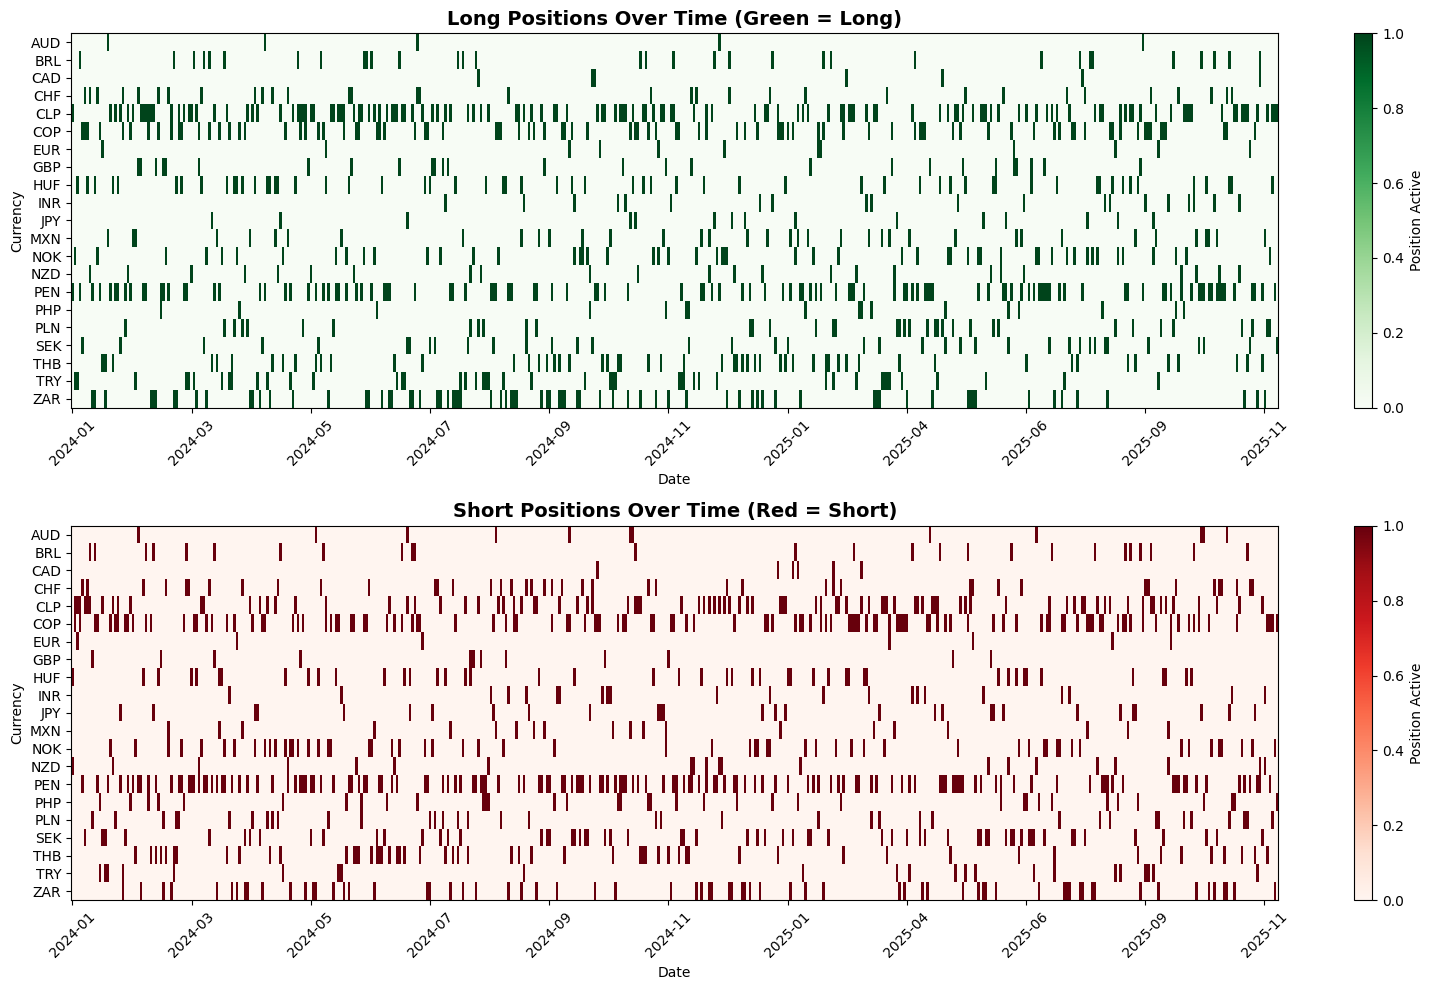


SIGNAL STATISTICS BY CURRENCY (OOS)
     Days Long  Days Short  Total Days  Long %  Short %
PEN        119         147         266    25.0     30.9
CLP        144          92         236    30.3     19.3
COP         92         122         214    19.3     25.6
ZAR         76          69         145    16.0     14.5
NOK         53          59         112    11.1     12.4
THB         56          56         112    11.8     11.8
HUF         59          46         105    12.4      9.7
SEK         38          64         102     8.0     13.4
CHF         33          44          77     6.9      9.2
PLN         38          38          76     8.0      8.0
TRY         46          23          69     9.7      4.8
BRL         33          26          59     6.9      5.5
MXN         38          20          58     8.0      4.2
PHP         17          37          54     3.6      7.8
NZD         24          21          45     5.0      4.4
JPY         15          29          44     3.2      6.1
INR        

In [69]:
# Plot signal heatmaps
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

# Long signals heatmap
long_plot = final_long_sig.T.astype(int)
im1 = ax1.imshow(long_plot, aspect='auto', cmap='Greens', interpolation='nearest')
ax1.set_yticks(range(len(long_plot.index)))
ax1.set_yticklabels(long_plot.index)
ax1.set_xlabel('Date')
ax1.set_ylabel('Currency')
ax1.set_title('Long Positions Over Time (Green = Long)', fontsize=14, fontweight='bold')
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
# Set x-axis labels
date_positions = range(0, len(long_plot.columns), max(1, len(long_plot.columns)//10))
ax1.set_xticks(date_positions)
ax1.set_xticklabels([long_plot.columns[i].strftime('%Y-%m') for i in date_positions], rotation=45)
plt.colorbar(im1, ax=ax1, label='Position Active')

# Short signals heatmap
short_plot = final_short_sig.T.astype(int)
im2 = ax2.imshow(short_plot, aspect='auto', cmap='Reds', interpolation='nearest')
ax2.set_yticks(range(len(short_plot.index)))
ax2.set_yticklabels(short_plot.index)
ax2.set_xlabel('Date')
ax2.set_ylabel('Currency')
ax2.set_title('Short Positions Over Time (Red = Short)', fontsize=14, fontweight='bold')
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
date_positions = range(0, len(short_plot.columns), max(1, len(short_plot.columns)//10))
ax2.set_xticks(date_positions)
ax2.set_xticklabels([short_plot.columns[i].strftime('%Y-%m') for i in date_positions], rotation=45)
plt.colorbar(im2, ax=ax2, label='Position Active')

plt.tight_layout()
plt.show()

# Summary statistics by currency
print("\n" + "="*60)
print("SIGNAL STATISTICS BY CURRENCY (OOS)")
print("="*60)
summary = pd.DataFrame({
    'Days Long': final_long_sig.sum(),
    'Days Short': final_short_sig.sum(),
    'Total Days': final_long_sig.sum() + final_short_sig.sum(),
    'Long %': (final_long_sig.sum() / len(final_long_sig) * 100).round(1),
    'Short %': (final_short_sig.sum() / len(final_short_sig) * 100).round(1)
})
summary = summary.sort_values('Total Days', ascending=False)
print(summary)
print("="*60)

In [70]:
oos_by_tone = oos_long.copy()
oos_by_tone['tone_rank'] = oos_by_tone.groupby('date')['avg_tone'].rank(ascending=False, method='first')
oos_by_tone

,date,currency,avg_tone,tone_dispersion,event_count,next_day_return,tone_rank
0,2024-01-01,AUD,-0.941811,3.931542,797.0,0.001466,9.0
1,2024-01-02,AUD,-0.868966,4.201793,1057.0,0.006623,7.0
2,2024-01-03,AUD,-1.976201,4.073011,1363.0,0.004409,12.0
3,2024-01-04,AUD,-2.351942,3.978708,1356.0,0.004385,12.0
4,2024-01-05,AUD,-1.407843,3.757750,1210.0,-0.001462,9.0
...,...,...,...,...,...,...,...
9991,2025-11-11,ZAR,-2.547049,4.723342,253.0,0.000374,17.0
9992,2025-11-12,ZAR,-2.958619,4.833453,328.0,-0.003778,19.0
9993,2025-11-13,ZAR,-2.195537,4.931440,335.0,-0.002848,19.0
9994,2025-11-14,ZAR,-2.890630,4.918916,321.0,0.002559,21.0
